In [1]:
import spectral as sp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import sys
import scipy.io


sys.path.append('../')
from preprocessing import *
from plotting_parameters import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, Bbox
from mpl_toolkits.axes_grid1 import make_axes_locatable
# matplotlib.use("wxAgg")
%matplotlib inline
set_plotting_style("latex")
set_plotting_style("default")

In [2]:
def l1_normalize(img, threshold=0):
    '''
    Normalize the image spectral signatures pixel-wise to unit L1 norm.
    Spectral dimension must be the last dimension.
    input:
        img: image to normalize, shape (...,k) where k is the number of bands and ... are the spatial or time dimensions
        threshold: percentile of L1 norm for which the spectrum is set to zero
    output:
        image as np.array
    '''
    img = get_array(img)
    norm = np.linalg.norm(img, ord=1, axis=-1, keepdims=True)

    # set pixels with low norm to zero
    norm_min = np.percentile(norm, threshold)
    img[np.where(norm<norm_min),:] = 0

    img = np.divide(img, norm)
    return img

### "Good" spectras from the first recording day before and after processing

(1, 460)
(1, 460)
(1, 460)
(1, 460)
(1, 460)
(1, 460)
(1, 460)
(1, 460)
(1, 460)
(1, 460)
(1, 460)
(1, 460)
(1, 460)
(1, 460)
(1, 460)
(1, 460)
(1, 460)
(1, 460)
(1, 460)
(1, 460)


C:\Users\User\AppData\Local\Temp\ipykernel_16440\2223600603.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1,5,figsize=(20, 4))


(1, 460)
(1, 460)
(1, 460)


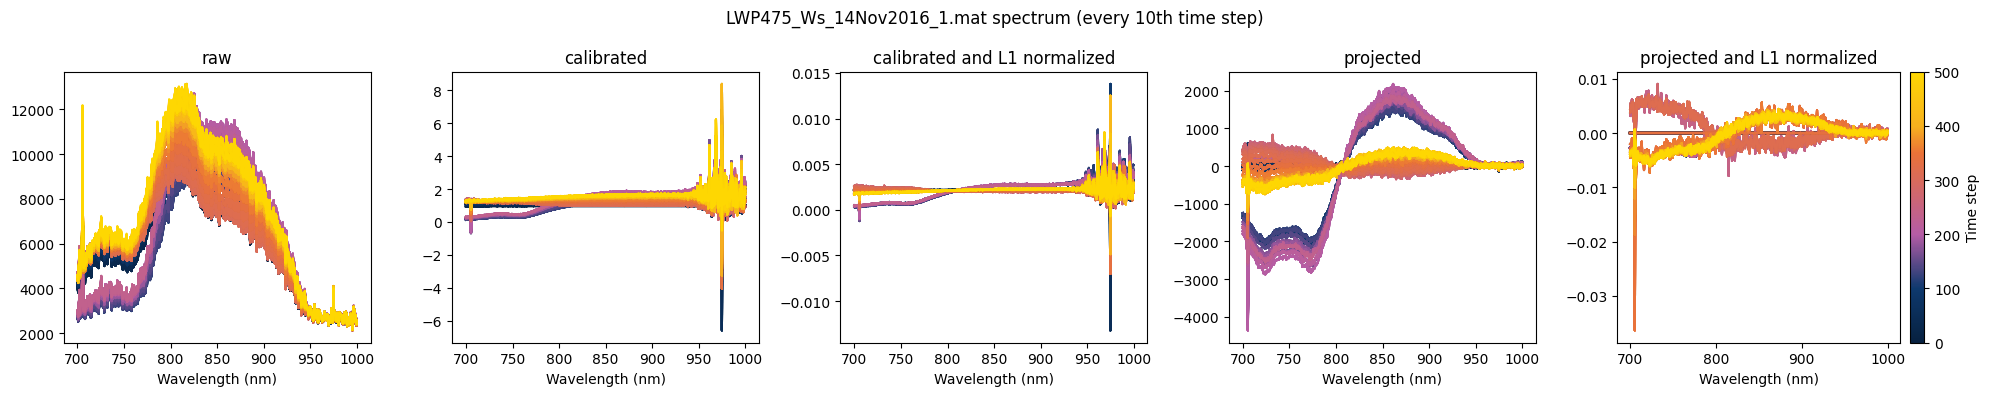

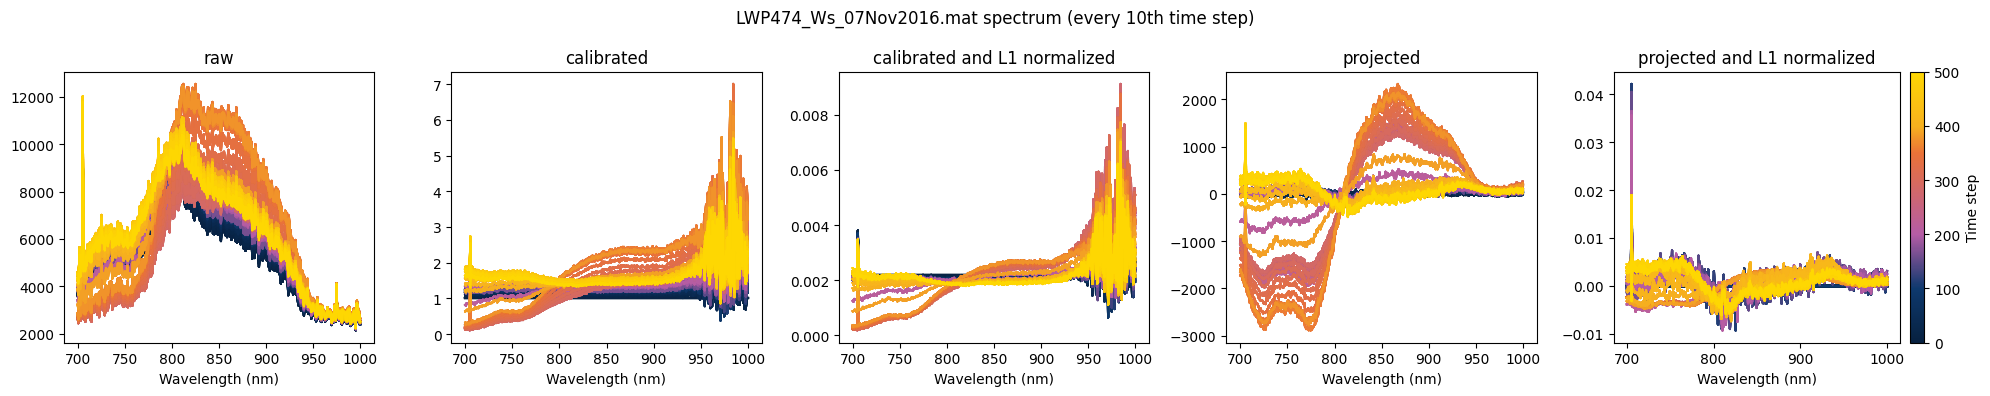

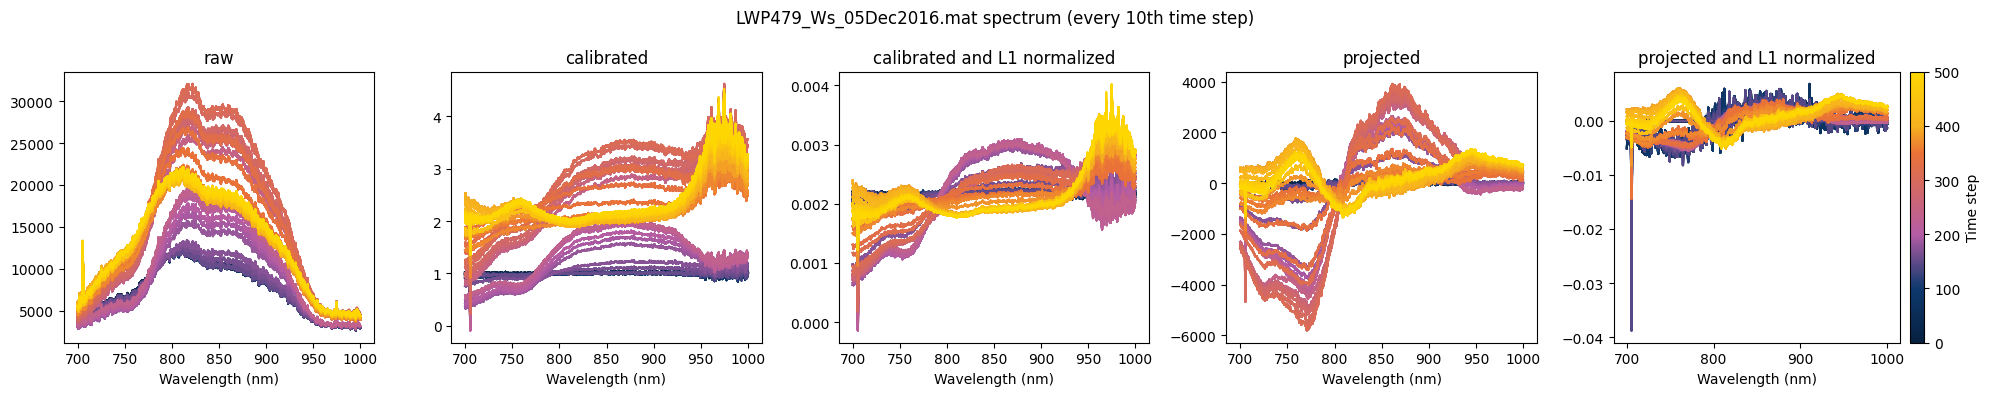

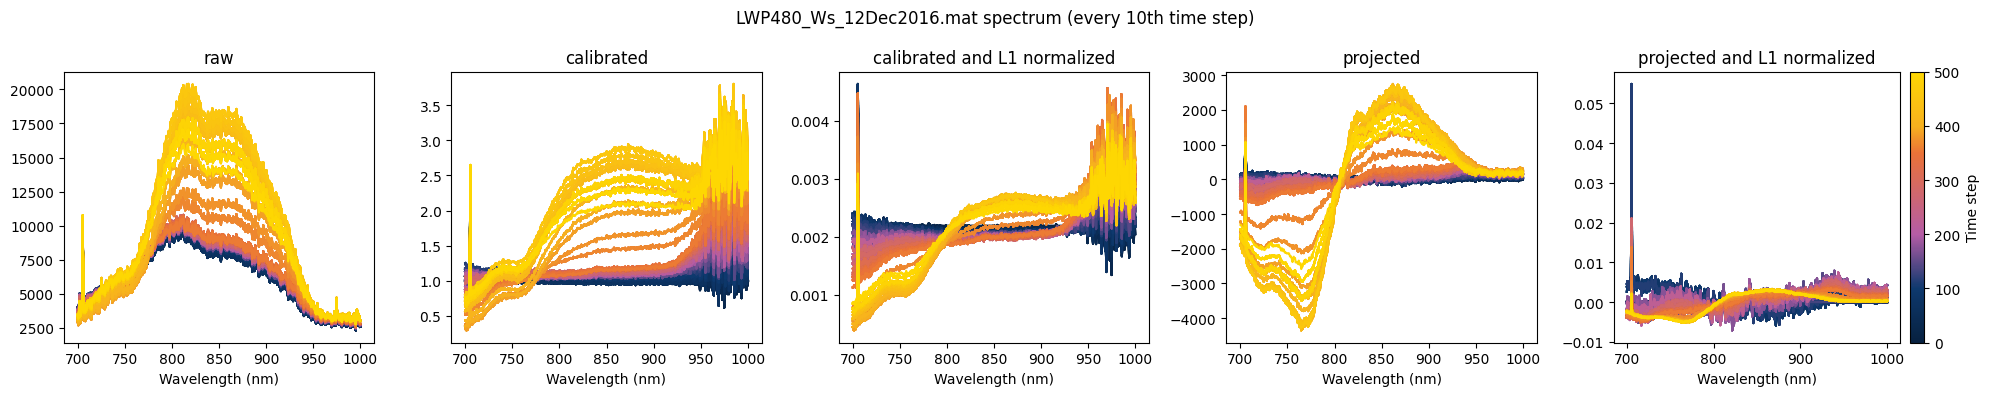

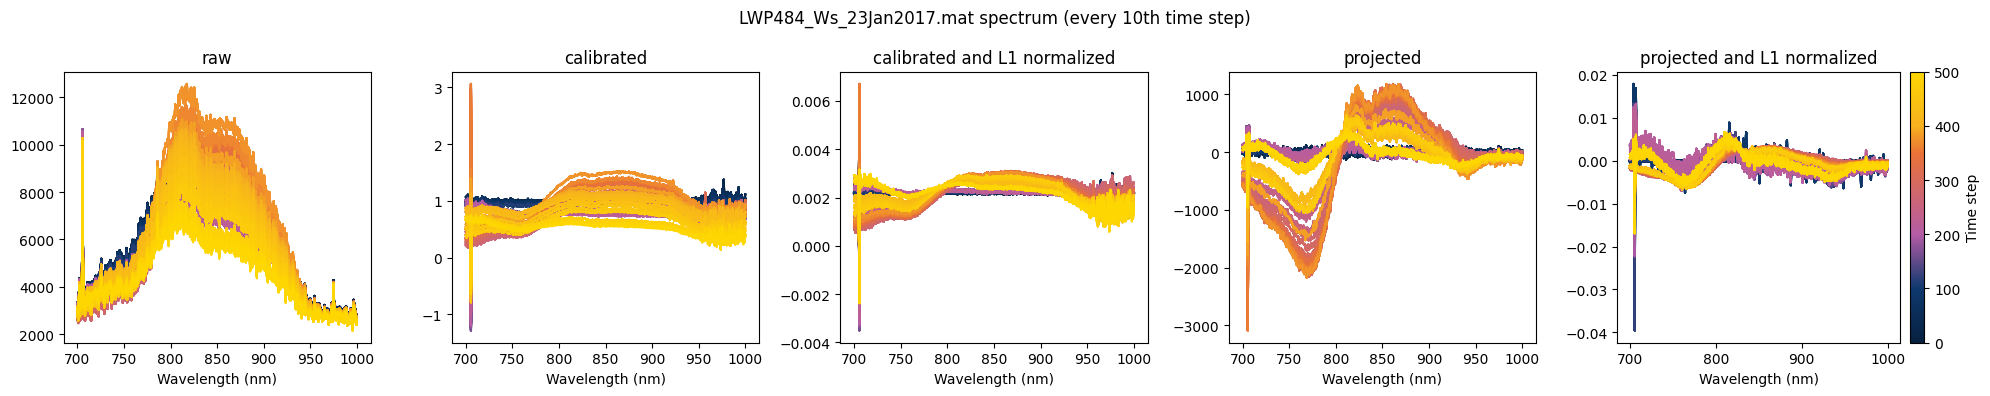

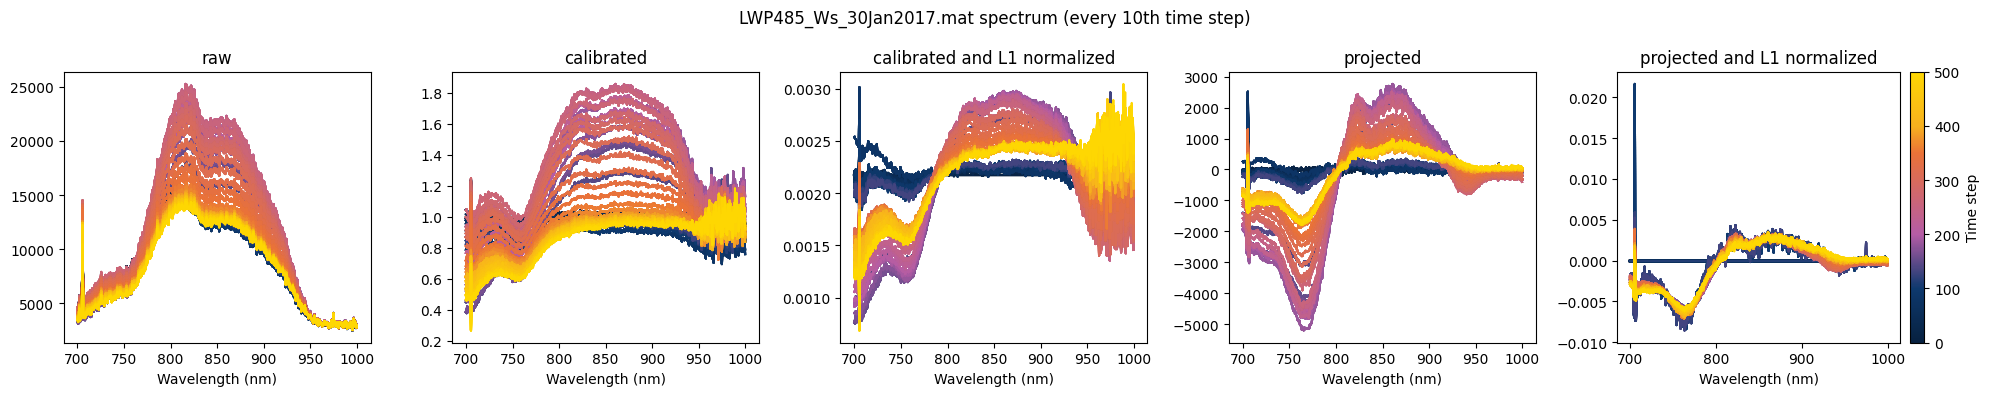

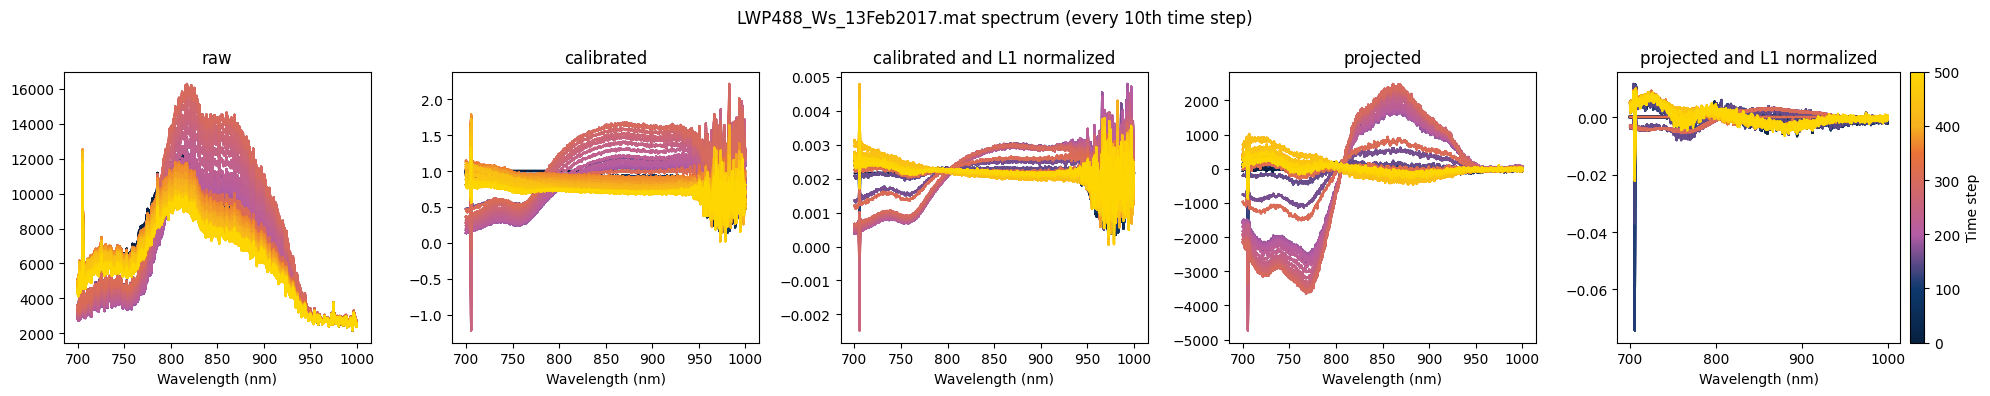

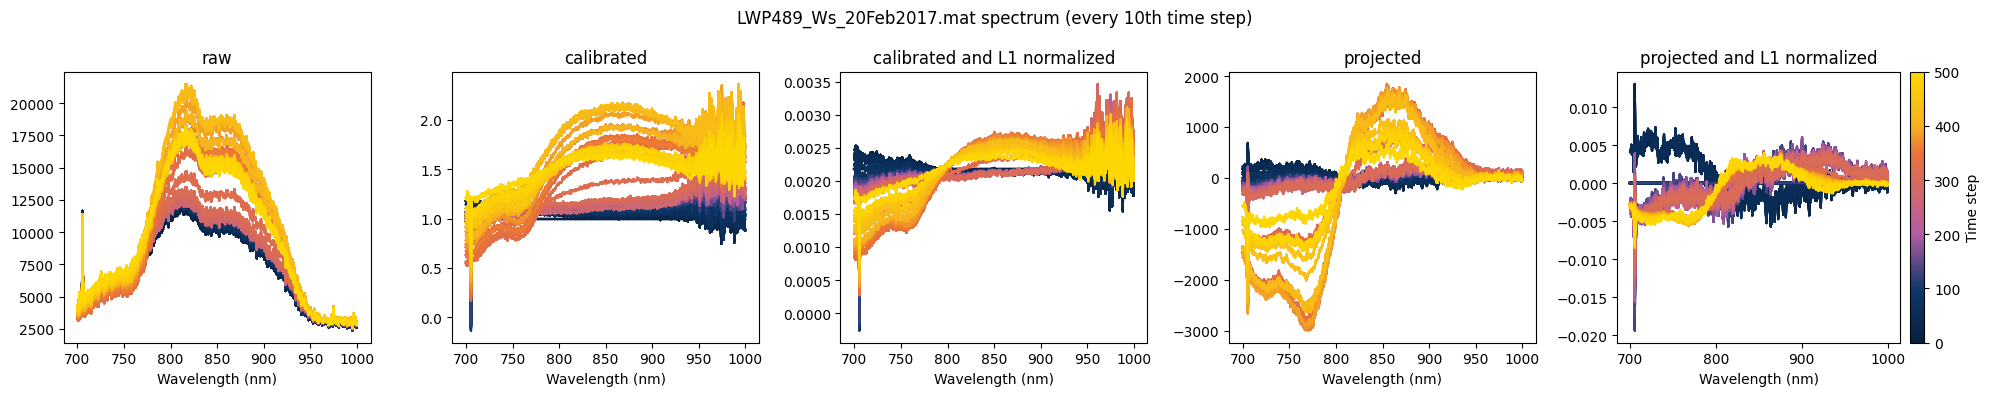

In [16]:
xlsx_path = "../datasets/piglet/overview.xlsx"
df = pd.read_excel(xlsx_path, sheet_name="Sheet1", engine="openpyxl")

dataset_path = "../datasets/piglet/"
time_steps = 500
for i in range(len(df)):

    if df.good[i] != "Yes":
        continue

    piglet = df.piglet[i]

    img_mat = scipy.io.loadmat(dataset_path + piglet + "/" + df.spectrum[i])
    band_centers = np.asarray(img_mat['wavelengths'].astype(float)).squeeze()
    spectr = img_mat['spectralDataAll'].astype(float)[:,0:time_steps:10].T # shape (time_steps, k)
    white_ref= img_mat['refIntensity'].astype(float) # shape (k,m)
    dark_ref = scipy.io.loadmat(dataset_path + piglet + "/" + df.darkCount[i])["DarkCount"].astype(float) # shape (k,n)
    concentrations = img_mat['allConcent'].astype(float)

    # average dark and white reference and add dimension for shape (1,k)
    white_ref = np.mean(white_ref, axis=-1)[np.newaxis, :]
    dark_ref = np.mean(dark_ref, axis=-1)[np.newaxis, :]
    
    # extract wavelengths between 760 and 900
    band_limits = [760, 900]
    spectr, _ = band_removal(spectr, band_limits, band_centers)
    white_ref, _ = band_removal(white_ref, band_limits, band_centers)
    dark_ref, band_centers_new = band_removal(dark_ref, band_limits, band_centers)

    # smooth the spectra
    # m = 10
    # spectr, white_ref, dark_ref = smooth_spectral(spectr, m), smooth_spectral(white_ref, m), smooth_spectral(dark_ref, m)

    # plot the spectrum
    fig, axs = plt.subplots(1,5,figsize=(20, 4))
    # raw spectrum
    plot_spectrum(spectr, band_centers_new, fig, axs[0])
    axs[0].set_title(f"raw", fontsize=12)
    # calibrated spectrum
    sprectr_calib = calibrate_img(spectr, white_ref, dark_ref)
    plot_spectrum(sprectr_calib, band_centers_new, fig, axs[1])
    axs[1].set_title(f"calibrated", fontsize=12)
    # calibrated spectrum normalized
    sprectr_calib_norm = l1_normalize(sprectr_calib)
    plot_spectrum(sprectr_calib_norm, band_centers_new, fig, axs[2])
    axs[2].set_title(f"calibrated and L1 normalized", fontsize=12)
    # projected spectrum
    spectr_proj = project_img(spectr, white_ref, dark_ref)
    plot_spectrum(spectr_proj, band_centers_new, fig, axs[3])
    axs[3].set_title(f"projected", fontsize=12)
    # projected spectrum normalized
    spectr_proj_norm = l1_normalize(spectr_proj, threshold=20)
    plot = plot_spectrum(spectr_proj_norm, band_centers_new, fig, axs[4])
    axs[4].set_title(f"projected and L1 normalized", fontsize=12)
    # add descriptions
    fig.suptitle(f"{df.spectrum[i]} spectrum (every 10th time step)", fontsize=12)
    sm = plt.cm.ScalarMappable(cmap=tum_cmap, norm=plt.Normalize(0, time_steps))
    sm.set_array(np.arange(0, time_steps))  # Specify the array directly
    divider = make_axes_locatable(axs[4])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(sm, cax=cax, label=r"Time step")
    plt.tight_layout()

    # # plot the concentrations
    # fig, ax = plt.subplots()
    # ax.plot(concentrations.T[:time_steps,:4], label=["HHb","HbO2","oxCCo","HbT"])
    # ax.set_title(f"{df.spectrum[i]} concentrations", fontsize=12)
    # ax.legend()
